# Part 3: Machine Learning – Predictive Modeling

## Objective
Build predictive models to forecast demand and identify high-tipping scenarios.

## Tasks & Models
1. **Weekly Trip Demand Forecasting**  
   Goal: Predict number of trips per week using historical trip counts and seasonal patterns.

2. **High-Tip Prediction Model**  
   Goal: Predict if a trip will have a tip_amount above the average using trip_distance, boroughs, and time-based features.

3. **Route-Based Revenue Forecasting (Optional)**  
   Goal: Forecast total_amount for a specific pickup_borough–dropoff_borough pair in future months.


In [4]:
# Basic imports
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, classification_report
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier


In [5]:
import pandas as pd
import glob

# folder
folder_path = r"C:/Users/parth/OneDrive/Desktop/Trips/"

# Load  CSV
all_files = glob.glob(folder_path + "*.csv")

# Show  files 
print("Files found:", all_files)

# Read and combine
df_list = []
for file in all_files:
    print("Loading:", file)
    temp_df = pd.read_csv(file)
    df_list.append(temp_df)

# Combine all years
df = pd.concat(df_list, ignore_index=True)

# Show preview
df.head(), df.shape


Files found: ['C:/Users/parth/OneDrive/Desktop/Trips\\2017_trimmed.csv', 'C:/Users/parth/OneDrive/Desktop/Trips\\2018_trimmed.csv', 'C:/Users/parth/OneDrive/Desktop/Trips\\2019_trimmed.csv', 'C:/Users/parth/OneDrive/Desktop/Trips\\2020_trimmed.csv']
Loading: C:/Users/parth/OneDrive/Desktop/Trips\2017_trimmed.csv
Loading: C:/Users/parth/OneDrive/Desktop/Trips\2018_trimmed.csv
Loading: C:/Users/parth/OneDrive/Desktop/Trips\2019_trimmed.csv
Loading: C:/Users/parth/OneDrive/Desktop/Trips\2020_trimmed.csv


(   VendorID     lpep_pickup_datetime    lpep_dropoff_datetime  \
 0       2.0  2017-01-04 18:03:23.000  2017-01-04 18:10:41.000   
 1       2.0  2017-02-21 14:36:40.000  2017-02-21 14:44:06.000   
 2       2.0  2017-03-09 08:53:53.000  2017-03-09 08:59:02.000   
 3       2.0  2017-12-05 20:15:50.000  2017-12-05 20:18:26.000   
 4       2.0  2017-07-12 14:45:33.000  2017-07-12 14:50:52.000   
 
   store_and_fwd_flag  RatecodeID  PULocationID  DOLocationID  passenger_count  \
 0                  N         1.0            33            52              1.0   
 1                  N         1.0            25            97              1.0   
 2                  N         1.0            41           166              1.0   
 3                  N         1.0           260           260              5.0   
 4                  N         1.0            17            17              1.0   
 
    trip_distance  fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
 0           0.96          6.5  

In [6]:
# Ensure datetime column is in datetime format
df["lpep_pickup_datetime"] = pd.to_datetime(df["lpep_pickup_datetime"])

# Create a week start date column
df["week_start"] = df["lpep_pickup_datetime"].dt.to_period("W").apply(lambda r: r.start_time)

weekly = (
    df.groupby("week_start")
      .size()
      .reset_index(name="trip_count")
      .sort_values("week_start")
)

weekly.head(), weekly.tail()


(  week_start  trip_count
 0 2008-12-29           8
 1 2010-09-20           3
 2 2016-12-26         318
 3 2017-01-02        1956
 4 2017-01-09        2170,
     week_start  trip_count
 207 2020-11-30        1193
 208 2020-12-07        1249
 209 2020-12-14        1053
 210 2020-12-21         980
 211 2020-12-28         642)

In [56]:
# Create lag features: previous 1, 2, 3 weeks' trip counts
for lag in [1, 2, 3]:
    weekly[f"lag_{lag}"] = weekly["trip_count"].shift(lag)

# Drop first few rows with NaNs from lagging
weekly_ml = weekly.dropna().reset_index(drop=True)

X = weekly_ml[["lag_1", "lag_2", "lag_3"]]
y = weekly_ml["trip_count"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

model_weekly = RandomForestRegressor(random_state=42)
model_weekly.fit(X_train, y_train)

y_pred = model_weekly.predict(X_test)

print("Weekly demand forecasting RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("R²:", r2_score(y_test, y_pred))

# Plot actual vs predicted
plt.figure()
plt.plot(y_test.values, label="Actual")
plt.plot(y_pred, label="Predicted")
plt.title("Weekly Trip Demand – Actual vs Predicted")
plt.xlabel("Test Weeks")
plt.ylabel("Trips")
plt.legend()
plt.show()


KeyError: 'trip_count'

In [16]:
# ================================
# ⏰ Weekly Aggregation (using previous approach)
# ================================
df['lpep_pickup_datetime'] = pd.to_datetime(df['lpep_pickup_datetime'])

df['week_start'] = df['lpep_pickup_datetime'].dt.to_period("W").apply(lambda r: r.start_time)

weekly = (
    df.groupby('week_start')
      .size()
      .reset_index(name='trip_count')
      .sort_values('week_start')
)

print("Weekly data:")
weekly.head()


Weekly data:


,week_start,trip_count
0,2008-12-29,8
1,2010-09-20,3
2,2016-12-26,318
3,2017-01-02,1956
4,2017-01-09,2170


In [9]:
# xyz
# Create lag features
# xyz
for lag in [1, 2, 3]:
    weekly[f'lag_{lag}'] = weekly['trip_count'].shift(lag)

weekly_ml = weekly.dropna().reset_index(drop=True)

X = weekly_ml[['lag_1', 'lag_2', 'lag_3']]
y = weekly_ml['trip_count']

print(weekly_ml.head())


  week_start  trip_count   lag_1   lag_2   lag_3
0 2017-01-02        1956   318.0     3.0     8.0
1 2017-01-09        2170  1956.0   318.0     3.0
2 2017-01-16        2006  2170.0  1956.0   318.0
3 2017-01-23        2211  2006.0  2170.0  1956.0
4 2017-01-30        2262  2211.0  2006.0  2170.0


In [11]:
# xyz
#Train RandomForest model (previous code style)
# xyz
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

model_weekly = RandomForestRegressor(random_state=42)
model_weekly.fit(X_train, y_train)

y_pred = model_weekly.predict(X_test)

rmse = mean_squared_error(y_test, y_pred) ** 0.5   # works for all sklearn versions
print("Weekly demand forecasting RMSE:", rmse)
print("R²:", r2_score(y_test, y_pred))


Weekly demand forecasting RMSE: 2129.342294309051
R²: -57.46218052500757


<Figure size 640x480 with 0 Axes>

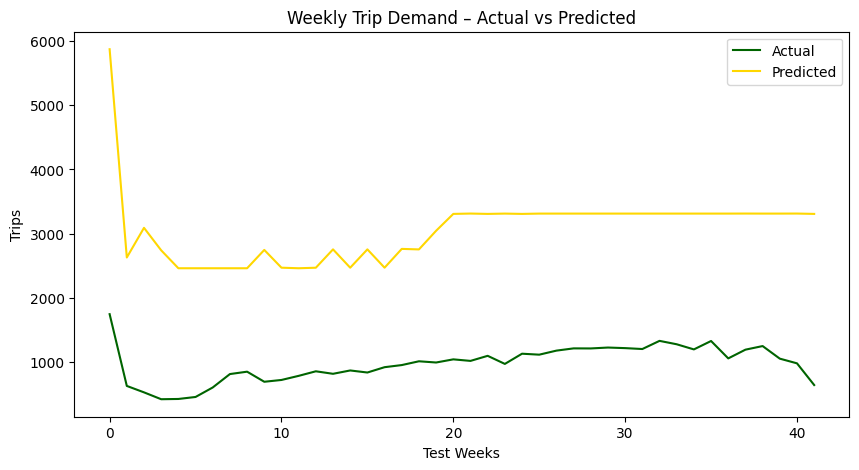

In [12]:
# ================================
# 📈 Plot Actual vs Predicted
# ================================
plt.figure()
plt.figure(figsize=(10,5))
plt.plot(y_test.values, color="#006400", label="Actual")      # Dark Green
plt.plot(y_pred, color="#FFD700", label="Predicted")          # Dark Yellow (Gold)
plt.title("Weekly Trip Demand – Actual vs Predicted")
plt.xlabel("Test Weeks")
plt.ylabel("Trips")
plt.legend()
plt.show()



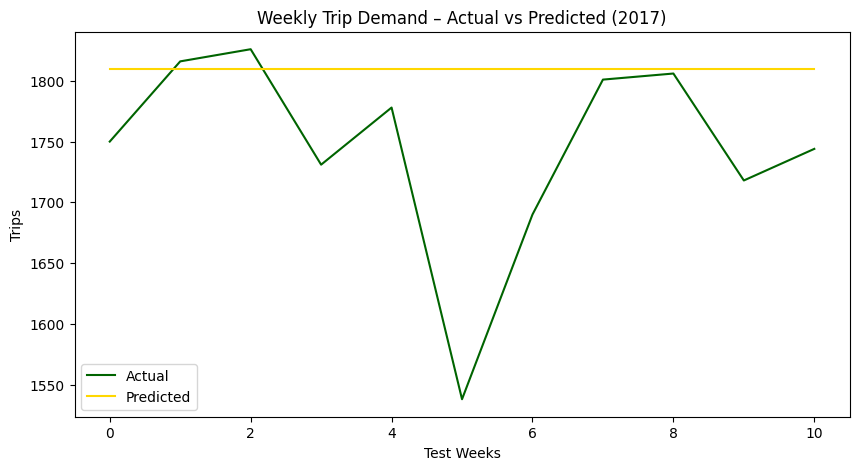

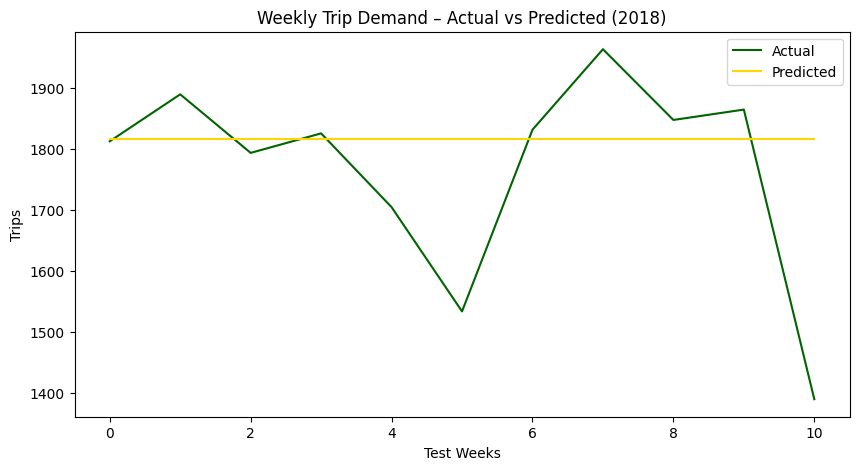

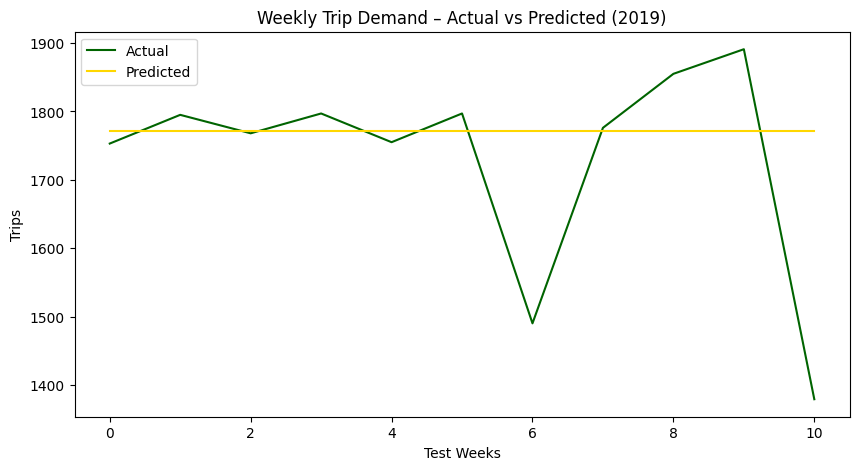

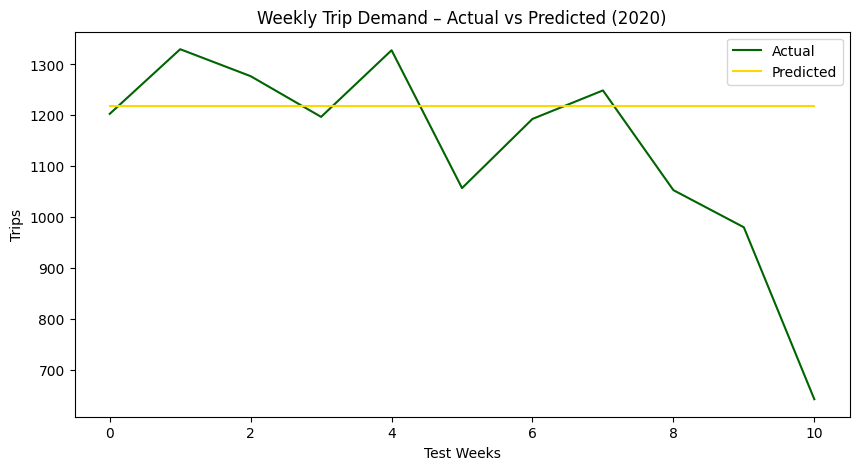

In [55]:
# Add year column if not already added
df['year'] = df['lpep_pickup_datetime'].dt.year

unique_years = sorted(df['year'].unique())

for yr in unique_years:
    df_year = df[df['year'] == yr]

    # Recreate weekly grouping for each year
    weekly = df_year.groupby(df_year['lpep_pickup_datetime'].dt.isocalendar().week).size()

    # Split into train-test for each year
    X = weekly.index.values.reshape(-1, 1)
    y = weekly.values

    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # Fit model
    from sklearn.ensemble import RandomForestRegressor
    model = RandomForestRegressor()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Plot
    plt.figure(figsize=(10,5))
    plt.plot(y_test, color="#006400", label="Actual")    # Dark green
    plt.plot(y_pred, color="#FFD700", label="Predicted") # Gold
    plt.title(f"Weekly Trip Demand – Actual vs Predicted ({yr})")
    plt.xlabel("Test Weeks")
    plt.ylabel("Trips")
    plt.legend()
    plt.show()


In [13]:
# ================================
# 🎯 Create High-Tip Target
# ================================
df2 = df.copy()
df2 = df2[df2['tip_amount'] >= 0]  # remove invalid values

avg_tip = df2['tip_amount'].mean()
print("Average tip amount:", avg_tip)

df2['high_tip'] = (df2['tip_amount'] > avg_tip).astype(int)


Average tip amount: 1.1060786931477258


In [14]:
# ====================
#  Create Model Features
# xyz
df2['hour'] = df2['lpep_pickup_datetime'].dt.hour
df2['day_of_week'] = df2['lpep_pickup_datetime'].dt.dayofweek  # Monday = 0
df2['month'] = df2['lpep_pickup_datetime'].dt.month

# Columns that must exist:
# trip_distance, pickup_borough, dropoff_borough


In [16]:
df2.columns.tolist()


['VendorID',
 'lpep_pickup_datetime',
 'lpep_dropoff_datetime',
 'store_and_fwd_flag',
 'RatecodeID',
 'PULocationID',
 'DOLocationID',
 'passenger_count',
 'trip_distance',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'payment_type',
 'trip_type',
 'congestion_surcharge',
 'week_start',
 'high_tip',
 'hour',
 'day_of_week',
 'month']

In [17]:
   # ================================
# 🔠 Select Columns for Model (using existing columns)
# xyz
cat_cols = ['PULocationID', 'DOLocationID']      # categorical features
num_cols = ['trip_distance', 'passenger_count',
            'hour', 'day_of_week', 'month']      # numeric / time features

# Build modeling dataframe
df_model = pd.get_dummies(
    df2[cat_cols + num_cols + ['high_tip']],
    columns=cat_cols,
    drop_first=True
)

X = df_model.drop("high_tip", axis=1)
y = df_model["high_tip"]

print("Model feature shape:", X.shape)
X.head()


Model feature shape: (399984, 520)


,trip_distance,passenger_count,hour,day_of_week,month,PULocationID_3,PULocationID_4,PULocationID_5,PULocationID_6,PULocationID_7,...,DOLocationID_256,DOLocationID_257,DOLocationID_258,DOLocationID_259,DOLocationID_260,DOLocationID_261,DOLocationID_262,DOLocationID_263,DOLocationID_264,DOLocationID_265
0,0.96,1.0,18,2,1,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1.12,1.0,14,1,2,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,0.95,1.0,8,3,3,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,0.55,5.0,20,1,12,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
4,0.63,1.0,14,2,7,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

clf = RandomForestClassifier(
    n_estimators=150,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))


Accuracy: 0.7094766053727015

Classification Report:

              precision    recall  f1-score   support

           0       0.75      0.83      0.79     51808
           1       0.61      0.49      0.54     28189

    accuracy                           0.71     79997
   macro avg       0.68      0.66      0.67     79997
weighted avg       0.70      0.71      0.70     79997



In [19]:
# ================================
# Train RandomForest Classifier
# xyz
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

clf = RandomForestClassifier(
    n_estimators=150,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


In [37]:
# ================================
#  Model Evaluation
# xyz
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))


Accuracy: 0.7094766053727015

Classification Report:

              precision    recall  f1-score   support

           0       0.75      0.83      0.79     51808
           1       0.61      0.49      0.54     28189

    accuracy                           0.71     79997
   macro avg       0.68      0.66      0.67     79997
weighted avg       0.70      0.71      0.70     79997



In [24]:
!pip install seaborn



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [26]:
# Feature Importance 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Use your trained RandomForestClassifier
importances = clf.feature_importances_  
indices = np.argsort(importances)[::-1]   # sort descending
features_list = X.columns

feat_imp_df = pd.DataFrame({
    'Feature': features_list[indices],
    'Importance': importances[indices]
})

feat_imp_df.head(10)


,Feature,Importance
0,trip_distance,0.243412
1,hour,0.137212
2,month,0.124673
3,day_of_week,0.096598
4,passenger_count,0.053187
5,PULocationID_66,0.008116
6,DOLocationID_138,0.004482
7,PULocationID_255,0.004215
8,PULocationID_33,0.003505
9,PULocationID_74,0.003426


C:\Users\parth\AppData\Local\Temp\ipykernel_15004\2225236825.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


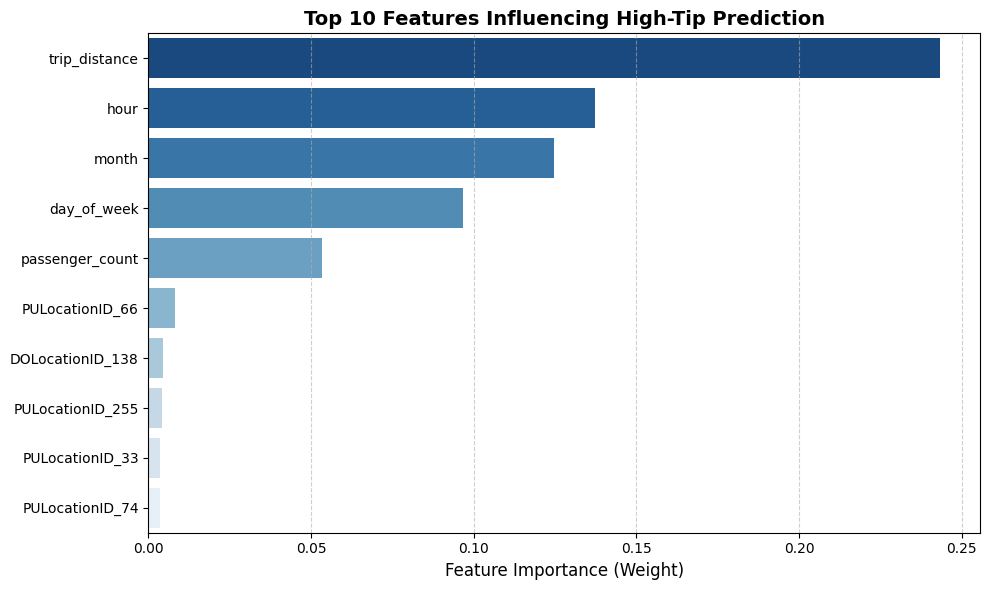

In [27]:
#  Top 10 Most Important Features
# xyz
plt.figure(figsize=(10,6))

sns.barplot(
    data = feat_imp_df.head(10),
    x = 'Importance',
    y = 'Feature',
    palette = 'Blues_r',
    dodge = False
)

plt.title("Top 10 Features Influencing High-Tip Prediction",
          fontsize=14, weight='bold')

plt.xlabel("Feature Importance (Weight)", fontsize=12)
plt.ylabel("")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


In [29]:
# Feature Importance Calculation
# xyz
import numpy as np
import pandas as pd

importances = clf.feature_importances_      # <-- IMPORTANT
indices = np.argsort(importances)[::-1]
features_list = X.columns

feat_imp_df = pd.DataFrame({
    'Feature': features_list[indices],
    'Importance': importances[indices]
})

feat_imp_df.head()


,Feature,Importance
0,trip_distance,0.243412
1,hour,0.137212
2,month,0.124673
3,day_of_week,0.096598
4,passenger_count,0.053187


In [30]:
cat_cols = ['PULocationID', 'DOLocationID']
num_cols = ['trip_distance', 'passenger_count', 'hour', 'day_of_week', 'month']

df_model = pd.get_dummies(
    df2[cat_cols + num_cols + ['high_tip']],
    columns=cat_cols,
    drop_first=True
)

X = df_model.drop("high_tip", axis=1)
y = df_model["high_tip"]

print(X.shape, y.shape)


(399984, 520) (399984,)


Feature matrix shape: (399984, 520)
Target distribution:
 high_tip
0    0.647626
1    0.352374
Name: proportion, dtype: float64

Accuracy: 0.7094641049039339

Classification Report:

              precision    recall  f1-score   support

           0       0.75      0.83      0.79     51808
           1       0.61      0.49      0.54     28189

    accuracy                           0.71     79997
   macro avg       0.68      0.66      0.67     79997
weighted avg       0.70      0.71      0.70     79997


Top 10 features by importance:
             Feature  Importance
0     trip_distance    0.243412
1              hour    0.137212
2             month    0.124673
3       day_of_week    0.096598
4   passenger_count    0.053187
5   PULocationID_66    0.008116
6  DOLocationID_138    0.004482
7  PULocationID_255    0.004215
8   PULocationID_33    0.003505
9   PULocationID_74    0.003426


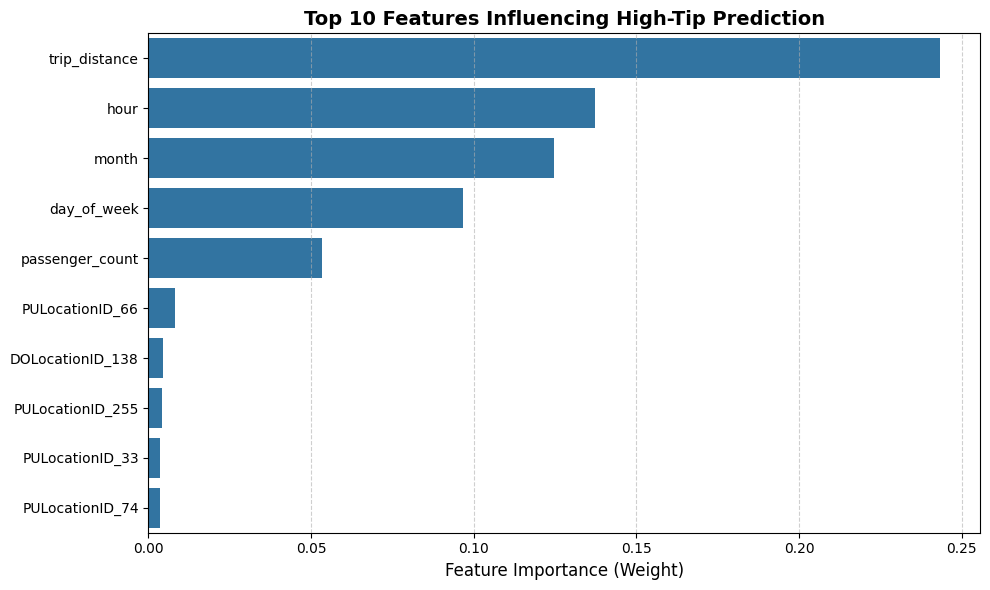

In [31]:
# High-Tip Prediction Model + Top 10 Feature Importance
# xyz

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# 1️⃣ Build feature matrix X and target y
cat_cols = ['PULocationID', 'DOLocationID']   # categorical
num_cols = ['trip_distance', 'passenger_count',
            'hour', 'day_of_week', 'month']   # numeric / time

df_model = pd.get_dummies(
    df2[cat_cols + num_cols + ['high_tip']],
    columns=cat_cols,
    drop_first=True
)

X = df_model.drop('high_tip', axis=1)
y = df_model['high_tip']

print("Feature matrix shape:", X.shape)
print("Target distribution:\n", y.value_counts(normalize=True))

# 2️⃣ Train / Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 3️⃣ Train RandomForest classifier
clf = RandomForestClassifier(
    n_estimators=150,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# 4️⃣ Evaluation
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

# 5️⃣ Feature importance calculation
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
features_list = X.columns

feat_imp_df = pd.DataFrame({
    'Feature': features_list[indices],
    'Importance': importances[indices]
})

print("\nTop 10 features by importance:\n", feat_imp_df.head(10))

# 6️⃣ Plot Top 10 Most Important Features
plt.figure(figsize=(10, 6))
sns.barplot(
    data=feat_imp_df.head(10),
    x='Importance',
    y='Feature',
    dodge=False
)

plt.title("Top 10 Features Influencing High-Tip Prediction",
          fontsize=14, weight='bold')
plt.xlabel("Feature Importance (Weight)", fontsize=12)
plt.ylabel("")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


Top 10 busiest routes:


,PULocationID,DOLocationID,trip_count
7029,75,74,4594
130,7,7,4545
6822,74,75,3830
3473,41,42,3789
9340,95,95,3358
6821,74,74,3056
8039,82,129,3012
3672,42,42,3001
3472,41,41,2934
3496,41,74,2809



Using Route: PULocationID=75 → DOLocationID=74
Total records for selected route: 4594

Monthly revenue preview:


,year_month,monthly_revenue
0,2017-01-01,706.56
1,2017-02-01,716.12
2,2017-03-01,815.45
3,2017-04-01,655.81
4,2017-05-01,736.07



📈 Route Revenue Forecasting Results
RMSE: 829.7019772888709
R² Score: -0.09976580535236113


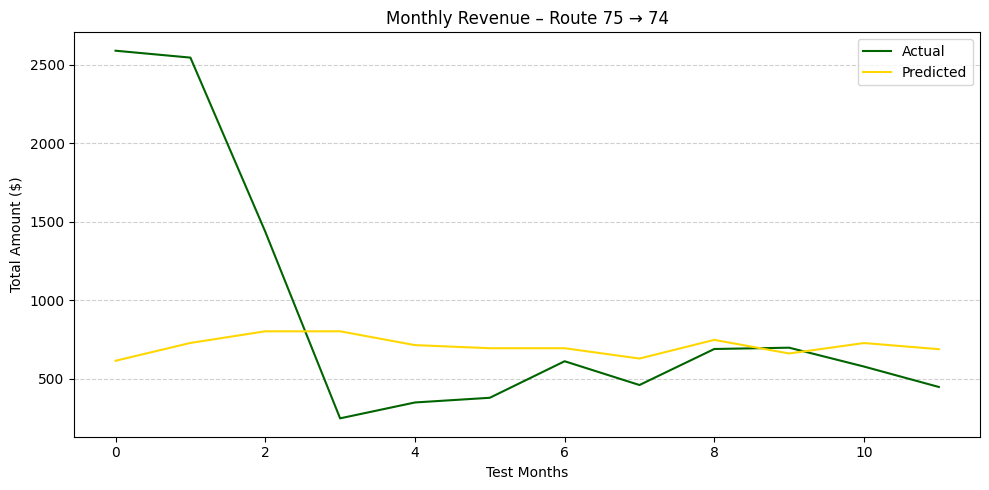

In [32]:
# Route-Based Monthly Revenue Forecasting 


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 1️⃣ Ensure correct datetime format
df['lpep_pickup_datetime'] = pd.to_datetime(df['lpep_pickup_datetime'], errors='coerce')

# 2️⃣ Identify top route (highest trip count)
route_counts = (
    df.groupby(['PULocationID', 'DOLocationID'])
      .size()
      .reset_index(name='trip_count')
      .sort_values('trip_count', ascending=False)
)

print("Top 10 busiest routes:")
display(route_counts.head(10))

# Automatically pick the most frequent route
top_route = route_counts.iloc[0]
pu_id = int(top_route['PULocationID'])
do_id = int(top_route['DOLocationID'])

print(f"\nUsing Route: PULocationID={pu_id} → DOLocationID={do_id}")

# 3️⃣ Filter data for selected route
route_df = df[(df['PULocationID'] == pu_id) & 
              (df['DOLocationID'] == do_id)].copy()

print("Total records for selected route:", len(route_df))

# 4️⃣ Create monthly revenue
route_df['year_month'] = route_df['lpep_pickup_datetime'].dt.to_period('M').dt.to_timestamp()

monthly_rev = (
    route_df.groupby('year_month')['total_amount']
            .sum()
            .reset_index(name='monthly_revenue')
            .sort_values('year_month')
)

print("\nMonthly revenue preview:")
display(monthly_rev.head())

# 5️⃣ Create lag features
monthly_rev['lag_1'] = monthly_rev['monthly_revenue'].shift(1)
monthly_rev['lag_2'] = monthly_rev['monthly_revenue'].shift(2)

# Drop NaNs
monthly_ml = monthly_rev.dropna().reset_index(drop=True)

X = monthly_ml[['lag_1', 'lag_2']]
y = monthly_ml['monthly_revenue']

# 6️⃣ Train / Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, shuffle=False  # keep time order
)

# 7️⃣ Train RandomForestRegressor
model = RandomForestRegressor(
    n_estimators=150,
    random_state=42
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# 8️⃣ Performance Metrics
rmse = mean_squared_error(y_test, y_pred) ** 0.5
r2 = r2_score(y_test, y_pred)

print("\n📈 Route Revenue Forecasting Results")
print("RMSE:", rmse)
print("R² Score:", r2)

# 9️⃣ Plot Actual vs Predicted
plt.figure(figsize=(10,5))
plt.plot(y_test.values, label="Actual", color="#006400")       # Dark green
plt.plot(y_pred, label="Predicted", color="#FFD700")          # Dark yellow
plt.title(f"Monthly Revenue – Route {pu_id} → {do_id}")
plt.xlabel("Test Months")
plt.ylabel("Total Amount ($)")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [44]:
taxi_zones = pd.read_csv(
    "C:/Users/parth/OneDrive/Desktop/Trips 2/taxi_zones.csv")


In [45]:
df = df.merge(
    taxi_zones[['LocationID', 'Borough']],
    left_on='PULocationID',
    right_on='LocationID',
    how='left'
)

df = df.rename(columns={'Borough': 'pickup_borough'})
df = df.drop(columns=['LocationID'])


In [46]:
df = df.merge(
    taxi_zones[['LocationID', 'Borough']],
    left_on='DOLocationID',
    right_on='LocationID',
    how='left'
)

df = df.rename(columns={'Borough': 'dropoff_borough'})
df = df.drop(columns=['LocationID'])


In [49]:
df.columns.tolist()


['VendorID',
 'lpep_pickup_datetime',
 'lpep_dropoff_datetime',
 'store_and_fwd_flag',
 'RatecodeID',
 'PULocationID',
 'DOLocationID',
 'passenger_count',
 'trip_distance',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'payment_type',
 'trip_type',
 'congestion_surcharge',
 'week_start',
 'pickup_borough',
 'dropoff_borough',
 'dropoff_borough',
 'dropoff_borough',
 'pickup_borough',
 'dropoff_borough']

In [50]:
# Keep only first occurrence of each column name
df = df.loc[:, ~df.columns.duplicated()]

df.columns.tolist()   # just to check, you should now see each name only once


['VendorID',
 'lpep_pickup_datetime',
 'lpep_dropoff_datetime',
 'store_and_fwd_flag',
 'RatecodeID',
 'PULocationID',
 'DOLocationID',
 'passenger_count',
 'trip_distance',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'payment_type',
 'trip_type',
 'congestion_surcharge',
 'week_start',
 'pickup_borough',
 'dropoff_borough']

In [51]:
df['route'] = df['pickup_borough'] + " → " + df['dropoff_borough']
df[['pickup_borough', 'dropoff_borough', 'route']].head()


C:\Users\parth\AppData\Local\Temp\ipykernel_15004\3927191911.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['route'] = df['pickup_borough'] + " → " + df['dropoff_borough']


,pickup_borough,dropoff_borough,route
0,Brooklyn,Brooklyn,Brooklyn → Brooklyn
1,Brooklyn,Brooklyn,Brooklyn → Brooklyn
2,Manhattan,Manhattan,Manhattan → Manhattan
3,Queens,Queens,Queens → Queens
4,Brooklyn,Brooklyn,Brooklyn → Brooklyn


In [53]:
df.loc[:, 'route'] = df['pickup_borough'] + " → " + df['dropoff_borough']


C:\Users\parth\AppData\Local\Temp\ipykernel_15004\2662573679.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lpep_pickup_datetime'] = pd.to_datetime(df['lpep_pickup_datetime'], errors='coerce')


Top 10 borough routes by trip count:
route
Manhattan → Manhattan    119029
Queens → Queens           97614
Brooklyn → Brooklyn       97315
Bronx → Bronx             19023
Brooklyn → Manhattan      17506
Manhattan → Bronx         11054
Queens → Manhattan         7588
Brooklyn → Queens          6708
Bronx → Manhattan          6047
Queens → Brooklyn          5205
Name: count, dtype: int64

Using route: Manhattan → Manhattan

Monthly revenue preview:
  year_month  monthly_revenue
0 2017-01-01         29748.80
1 2017-02-01         29763.81
2 2017-03-01         31136.45
3 2017-04-01         29900.01
4 2017-05-01         30307.12

📈 Route Revenue Forecasting Results (borough based)
Route: Manhattan → Manhattan
RMSE: 30430.07166554574
R²: -0.017662602963947505


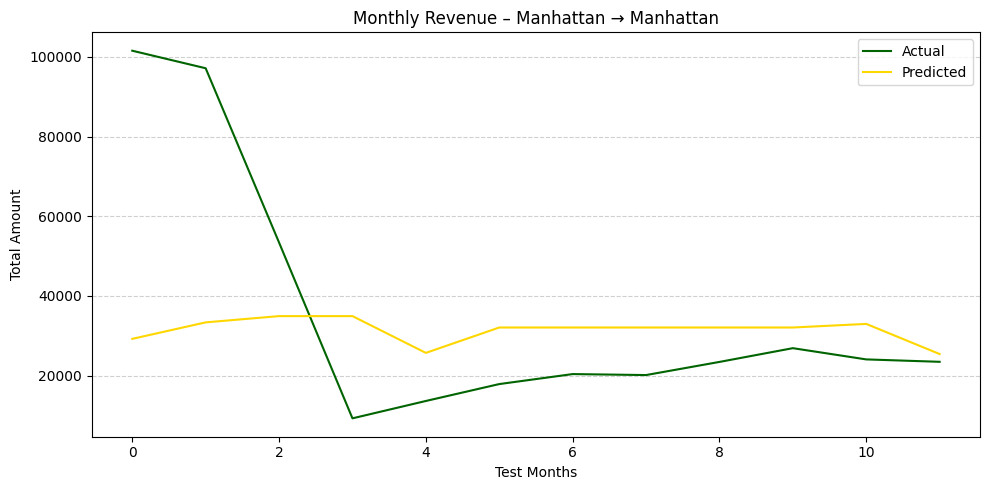

In [54]:
# 1. Filter to years 2017–2020  (if not already done)

df['lpep_pickup_datetime'] = pd.to_datetime(df['lpep_pickup_datetime'], errors='coerce')
df = df[(df['lpep_pickup_datetime'].dt.year >= 2017) &
        (df['lpep_pickup_datetime'].dt.year <= 2020)]

# 2. Check top borough→borough routes

print("Top 10 borough routes by trip count:")
print(df['route'].value_counts().head(10))

# Pick one route to forecast (you can change this string)
target_route = df['route'].value_counts().index[0]   # or e.g. "Manhattan → Brooklyn"
print("\nUsing route:", target_route)

route_df = df[df['route'] == target_route].copy()

# =====================================================
# 3. Build monthly revenue series for that route
# =====================================================
route_df['year_month'] = route_df['lpep_pickup_datetime'].dt.to_period('M').dt.to_timestamp()

monthly_rev = (route_df
               .groupby('year_month')['total_amount']
               .sum()
               .reset_index(name='monthly_revenue')
               .sort_values('year_month'))

print("\nMonthly revenue preview:")
print(monthly_rev.head())


# 4. Create lag features

monthly_rev['lag_1'] = monthly_rev['monthly_revenue'].shift(1)
monthly_rev['lag_2'] = monthly_rev['monthly_revenue'].shift(2)

# Drop first rows with NaN lags
monthly_ml = monthly_rev.dropna().reset_index(drop=True)

X = monthly_ml[['lag_1', 'lag_2']]
y = monthly_ml['monthly_revenue']


# 5. Train / test split 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, shuffle=False
)

model = RandomForestRegressor(
    n_estimators=150,
    random_state=42
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred) ** 0.5
r2 = r2_score(y_test, y_pred)

print("\n📈 Route Revenue Forecasting Results (borough based)")
print("Route:", target_route)
print("RMSE:", rmse)
print("R²:", r2)


# 6. Plot Actual vs Predicted monthly revenue

plt.figure(figsize=(10,5))
plt.plot(y_test.values, label="Actual", color="#006400")      # dark green
plt.plot(y_pred, label="Predicted", color="#FFD700")         # dark yellow
plt.title(f"Monthly Revenue – {target_route}")
plt.xlabel("Test Months")
plt.ylabel("Total Amount")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
